In [62]:
from ATVA1 import ATVA1
from BTVA import BTVA
from generate_test_cases import generate_test
from voting_schemes import *
from happiness_measure import *
from risk_measure import *
import pandas as pd
import random
import math

voting_schemes = [plurality_voting, anti_plurality_voting, borda_count_voting, two_person_voting]
risk_measures = [NaivePSV, WinnerChangeRisk, FlipRewardRisk, HappinessWeightedPSV]
happiness_measure = get_happiness # separate for easy hot-swap (possible: NDCG, KendallTau, BubbleSortDistance, get_happiness)

- change in delta-happiness and risk on small matrices compared to BTVA

In [18]:
# generate n small test cases
n = 10
num_voters = 8
num_candidates = 4
random.seed(0)
test_cases = [generate_test(num_candidates=num_candidates, num_voters=num_voters) for _ in range(n)]

In [29]:
output = [list() for _ in range(len(risk_measures))]

for i, risk_measure in enumerate(risk_measures):
    atva = ATVA1(happiness_measure=happiness_measure, risk_measure=risk_measure, maxCollusionSize=2, exhaustiveSearch=True)
    btva = BTVA(happiness_measure=happiness_measure, risk_measure=risk_measure)
    for voting_scheme in voting_schemes:
        output[i].append([])
        for test_case in test_cases:
            _, _, _, _, atva_risk = atva.analyze(test_case, voting_scheme)
            _, _, _, _, btva_risk = btva.analyze(test_case, voting_scheme)
            output[i][-1].append(atva_risk - btva_risk)

avg_output = [list() for _ in range(len(risk_measures))]
std_output = [list() for _ in range(len(risk_measures))]
for k in range(len(output)):
    for i in range(len(output[k])):
        avg_output[k].append(sum(output[k][i]) / len(output[k][i]))
        std_output[k].append(math.sqrt(sum((x - avg_output[k][-1])**2 for x in output[k][i]) / len(output[k][i])))

# avg and std risk difference for each risk measure and voting scheme
# other variables: n = , numvoters = , numcandidates = , happiness_measure = 

df_avg = pd.DataFrame(avg_output,
                  columns=['Plurality Voting', 'Anti-Plurality Voting', 'Borda Voting', 'Two-Person Voting'],
                  index=[f'risk measure #{i}' for i in range(len(risk_measures))]
)
print(df_avg)
df_std = pd.DataFrame(std_output,
                  columns=['Plurality Voting', 'Anti-Plurality Voting', 'Borda Voting', 'Two-Person Voting'],
                  index=[f'risk measure #{i}' for i in range(len(risk_measures))]
)
print(df_std)

                 Plurality Voting  Anti-Plurality Voting  Borda Voting  \
risk measure #0               0.0               0.062500      0.150000   
risk measure #1               0.0               0.044920      0.125317   
risk measure #2               0.0               0.194889      0.389777   
risk measure #3               0.0               0.062500      0.150000   

                 Two-Person Voting  
risk measure #0           0.100000  
risk measure #1           0.086364  
risk measure #2           0.292333  
risk measure #3           0.100000  
                 Plurality Voting  Anti-Plurality Voting  Borda Voting  \
risk measure #0               0.0               0.128087      0.192029   
risk measure #1               0.0               0.092382      0.162052   
risk measure #2               0.0               0.389777      0.477378   
risk measure #3               0.0               0.128087      0.192029   

                 Two-Person Voting  
risk measure #0           0.165831  

                      Plurality Voting  Anti-Plurality Voting  Borda Voting  \
risk_measure                                                                  
NaivePSV                           0.0               0.062500      0.150000   
WinnerChangeRisk                   0.0               0.044920      0.125317   
FlipRewardRisk                     0.0               0.194889      0.389777   
HappinessWeightedPSV               0.0               0.062500      0.150000   

                      Two-Person Voting  
risk_measure                             
NaivePSV                       0.100000  
WinnerChangeRisk               0.086364  
FlipRewardRisk                 0.292333  
HappinessWeightedPSV           0.100000  


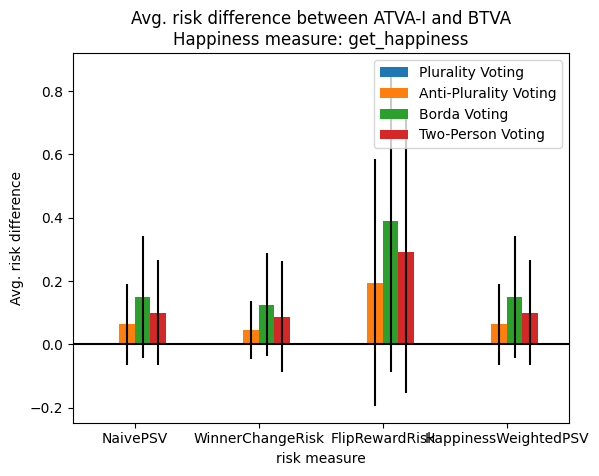

In [30]:
# dataframe shananigans
df2 = df_avg.reset_index()
df2 = df2.rename(columns={'index':'risk_measure'})
df2['risk_measure'] = df2['risk_measure'].apply(lambda x: risk_measures[int(x.split('#')[1])].__name__)
df2 = df2.set_index('risk_measure')
df3 = df_std.reset_index()
df3 = df3.rename(columns={'index':'risk_measure'})
df3['risk_measure'] = df3['risk_measure'].apply(lambda x: risk_measures[int(x.split('#')[1])].__name__)
df3 = df3.set_index('risk_measure')
print(df2)

ax = df2.plot(kind='bar',
         rot=0,
         yerr=df3,
         xlabel='risk measure',
         ylabel='Avg. risk difference',
         title=f'Avg. risk difference between ATVA-I and BTVA\nHappiness measure: {happiness_measure.__name__}'
)
ax.axhline(0, color='black');

- % of viable coalitions for large(r) matrices

In [43]:
# generate n large test cases
n = 10
num_voters = 8
num_candidates = 3
random.seed(0)
test_cases = [generate_test(num_candidates=num_candidates, num_voters=num_voters) for _ in range(n)]

In [63]:
max_collusion_size = math.ceil(num_voters / 2)

output = [list() for _ in range(max_collusion_size + 1)]

for k in range(1, max_collusion_size + 1): # collusion size
    print(k)
    atva = ATVA1(happiness_measure=happiness_measure, maxCollusionSize=k)
    for voting_scheme in voting_schemes:
        output[k].append([])
        for test_case in test_cases:
            _, _, _, collusion_options, _ = atva.analyze(test_case, voting_scheme)
            output[k][-1].append(len(collusion_options) / math.comb(num_voters, k))

avg_output = [list() for _ in range(max_collusion_size + 1)]
std_output = [list() for _ in range(max_collusion_size + 1)]
for k in range(1, max_collusion_size + 1):
    for i in range(len(output[k])):
        avg_output[k].append(sum(output[k][i]) / len(output[k][i]))
        std_output[k].append(math.sqrt(sum((x - avg_output[k][-1])**2 for x in output[k][i]) / len(output[k][i])))

# avg. percentage of collusion options that were successful per voting scheme and collusion size
# other variables: n = , numvoters = , numcandidates = , happiness_measure = 

df_avg = pd.DataFrame(avg_output[1:],
                  columns=['Plurality Voting', 'Anti-Plurality Voting', 'Borda Voting', 'Two-Person Voting'],
                  index=[f'k={k}' for k in range(1, max_collusion_size + 1)]
)
print(df_avg)
df_std = pd.DataFrame(std_output[1:],
                  columns=['Plurality Voting', 'Anti-Plurality Voting', 'Borda Voting', 'Two-Person Voting'],
                  index=[f'k={k}' for k in range(1, max_collusion_size + 1)]
)
print(df_std)

1
2
3
4
     Plurality Voting  Anti-Plurality Voting  Borda Voting  Two-Person Voting
k=1               0.0               0.012500      0.037500           0.012500
k=2               0.0               0.007143      0.010714           0.007143
k=3               0.0               0.001786      0.007143           0.001786
k=4               0.0               0.000000      0.001429           0.000000
     Plurality Voting  Anti-Plurality Voting  Borda Voting  Two-Person Voting
k=1               0.0               0.037500      0.112500           0.037500
k=2               0.0               0.014286      0.032143           0.014286
k=3               0.0               0.005357      0.021429           0.005357
k=4               0.0               0.000000      0.004286           0.000000


   Plurality Voting  Anti-Plurality Voting  Borda Voting  Two-Person Voting
k                                                                          
1               0.0               0.012500      0.037500           0.012500
2               0.0               0.007143      0.010714           0.007143
3               0.0               0.001786      0.007143           0.001786
4               0.0               0.000000      0.001429           0.000000


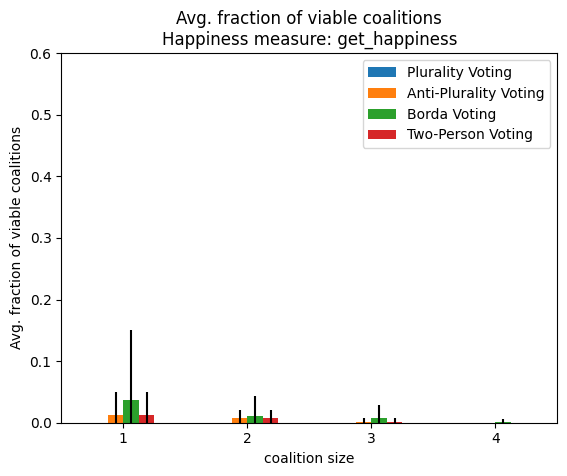

In [64]:
# dataframe shananigans
df2 = df_avg.reset_index()
df2 = df2.rename(columns={'index':'k'})
df2['k'] = df2['k'].apply(lambda x: int(x.split('=')[1]))
df2 = df2.set_index('k')
df3 = df_std.reset_index()
df3 = df3.rename(columns={'index':'k'})
df3['k'] = df3['k'].apply(lambda x: int(x.split('=')[1]))
df3 = df3.set_index('k')
print(df2)

ax = df2.plot(kind='bar',
         rot=0,
         yerr=df3,
         xlabel='coalition size',
         ylabel='Avg. fraction of viable coalitions',
         title=f'Avg. fraction of viable coalitions\nHappiness measure: {happiness_measure.__name__}',
         ylim=(0, 0.6)
);